# キオクシアホールディング ５分足

In [1]:
import sys
import os
try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '285A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1d', interval='5m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-03-05 09:05:00+09:00,2494.0,2520.0,2470.0,2513.0,237200,0.0,0.0
2025-03-05 09:10:00+09:00,2515.0,2527.0,2475.0,2479.0,427900,0.0,0.0
2025-03-05 09:15:00+09:00,2479.0,2480.0,2435.0,2443.0,313700,0.0,0.0
2025-03-05 09:20:00+09:00,2444.0,2449.0,2412.0,2417.0,258100,0.0,0.0
2025-03-05 09:25:00+09:00,2416.0,2429.0,2389.0,2410.0,285900,0.0,0.0
2025-03-05 09:30:00+09:00,2411.0,2423.0,2372.0,2379.0,310300,0.0,0.0
2025-03-05 09:35:00+09:00,2379.0,2403.0,2374.0,2392.0,121900,0.0,0.0
2025-03-05 09:40:00+09:00,2393.0,2413.0,2388.0,2411.0,114200,0.0,0.0
2025-03-05 09:45:00+09:00,2410.0,2428.0,2410.0,2418.0,197000,0.0,0.0


## 日足チャートとパラボリック SAR

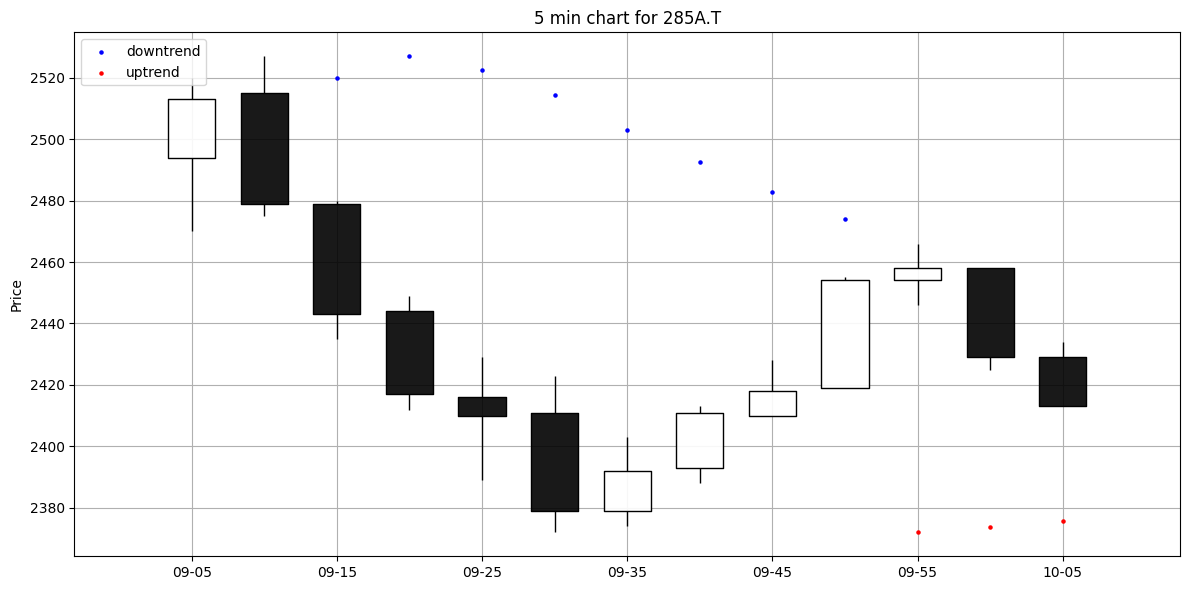

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=False,
    datetime_format='%H-%M',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('5 min chart for %s (%s)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('5 min chart for %s' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('5min_chart_%s.png' % m.group(1))
else:
    plt.savefig('5min_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Datetime
2025-03-05 10:00:00+09:00    2429.0
2025-03-05 10:05:00+09:00    2413.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Datetime
2025-03-05 10:00:00+09:00     NaN
2025-03-05 10:05:00+09:00   -16.0
Name: Close, dtype: float64